# Hierarchical Clustering Build Structural Topic Model on NEH Grant Products

<b>Author:</b> Jaren Haber, PhD <br>
<b>Date</b>: October 27, 2023 <br>
<b>Description</b>: Estimates hierarchical clustering model, analyzes results, and generates visualizations. <br>
<b>Sources</b>: Code snippets and inspiration borrowed from [my team's work here](https://github.com/h2researchgroup/embeddings/blob/main/clustering/hierarchical_by_decade.ipynb) and [this template viz code from scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) <br>
<b>Required packages</b> (to install): pandas, scikit-learn, scipy, numpy, seaborn <br>

## Introduction

Cortez et al. (2009) analyzed the effects of physiochemical properties of white and red *vinho verde* wines (from Portugal) on their sensory preference, i.e. their perceived quality. Using machine learning models (SVM in particular), they ranked wine properties from most to least important for determinining wine quality by type (red or white) as follows:

**Red wine**:
1. sulphates
2. pH
3. total sulfur dioxide
4. alcohol
5. volatile acidity
6. free sulfur dioxide
7. fixed acidity
8. residual sugar
9. chlorides
10. density
11. citric acid

**White wine:**
1. sulphates
2. alcohol
3. residual sugar
4. citric acid
5. total sulfur dioxide
6. free sulfur dioxide
7. volatile acidity
8. density
9. pH
10. chlorides
11. fixed acidity

Using the [cleaned wine dataset shared publicly by Cortez et al. (2009)](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/), I extend on this study by addressing the following **research question:**

**What properties of each wine type differentiate clusters of differing levels of quality?**

Rather than using machine learning or regression to identify which *individual* properties matter most, here I use clustering methods to analyze what *groups* of properties are most significant. In particular, I use visualization (t-SNE) and hierarchical clustering to determine most likely cluster counts, compute the clusters using *k*-means clustering, and compare their standardized attributes to find what properties "hang together" in distinct ways between clusters.

**Citation:** <br>
Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. *Decision Support Systems*, 47(4), 547–553. https://doi.org/10.1016/j.dss.2009.05.016

## Summary

* Clustering appears successful in capturing differences between wine types (red and white) and combinations of features within wine types connected with perceptions of quality
* Both wine types show two distinct clusters through hierarchical clustering (though these are not as distinct visually), with one cluster about a third of a standard deviation higher than the other
* The red wine clusters are differentiated by different groups of features than the white wine clusters: Red wines do better if they are more like white wines (lower acidity and sulphates), while better-tasting white wines are sweeter (higher sugar and density), lower in alcohol, and higher in sulfur dioxide.

## Initialize

In [250]:
# Import generic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
from os.path import join, isfile, isdir, basename
from collections import Counter
import joblib

# Import packages for modeling & clustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler # for normalizing & standardizing features
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE # For visualizing relationships

# Import local function(s)
from utils import *

# Show multiple outputs for same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import data from web

In [2]:
# Define URL of zipped file
data_url = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'
fpath = '../data'

# Download zipped file and extract
get_unzip(data_url, fpath)

## Prepare data

### Combine data for both wine types

In [3]:
# Define file suffixes for wine types
wine_types = [
    'red', 
    'white'
]

In [312]:
## Load each wine type and combine into one DataFrame
dfs = [] # Create empty list for both wine DataFrames

# Loop over wine types and add to list of DFs
for color in wine_types: 
    wine_df = pd.read_csv(join('../data/', f'winequality-{color}.csv'), low_memory=False, sep=";")
    wine_df['wine type'] = color # add column for wine type
    dfs.append(wine_df)
    
df = pd.concat(dfs) # Combine DFs into one

In [326]:
# Inspect full data
print("Count of rows, columns in full data:", df.shape)
print(f"These are the {str(len(df.columns))} column names:")
print(", ".join([col for col in df.columns]))
print()
df.describe() # show statistics for each feature

Count of rows, columns in full data: (6497, 13)
These are the 13 column names:
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality, red



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


## Evaluate data quality

### Examine missingness

In [9]:
# Check whether any column has a missing value anywhere
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
wine type               False
dtype: bool

### Examine distributions

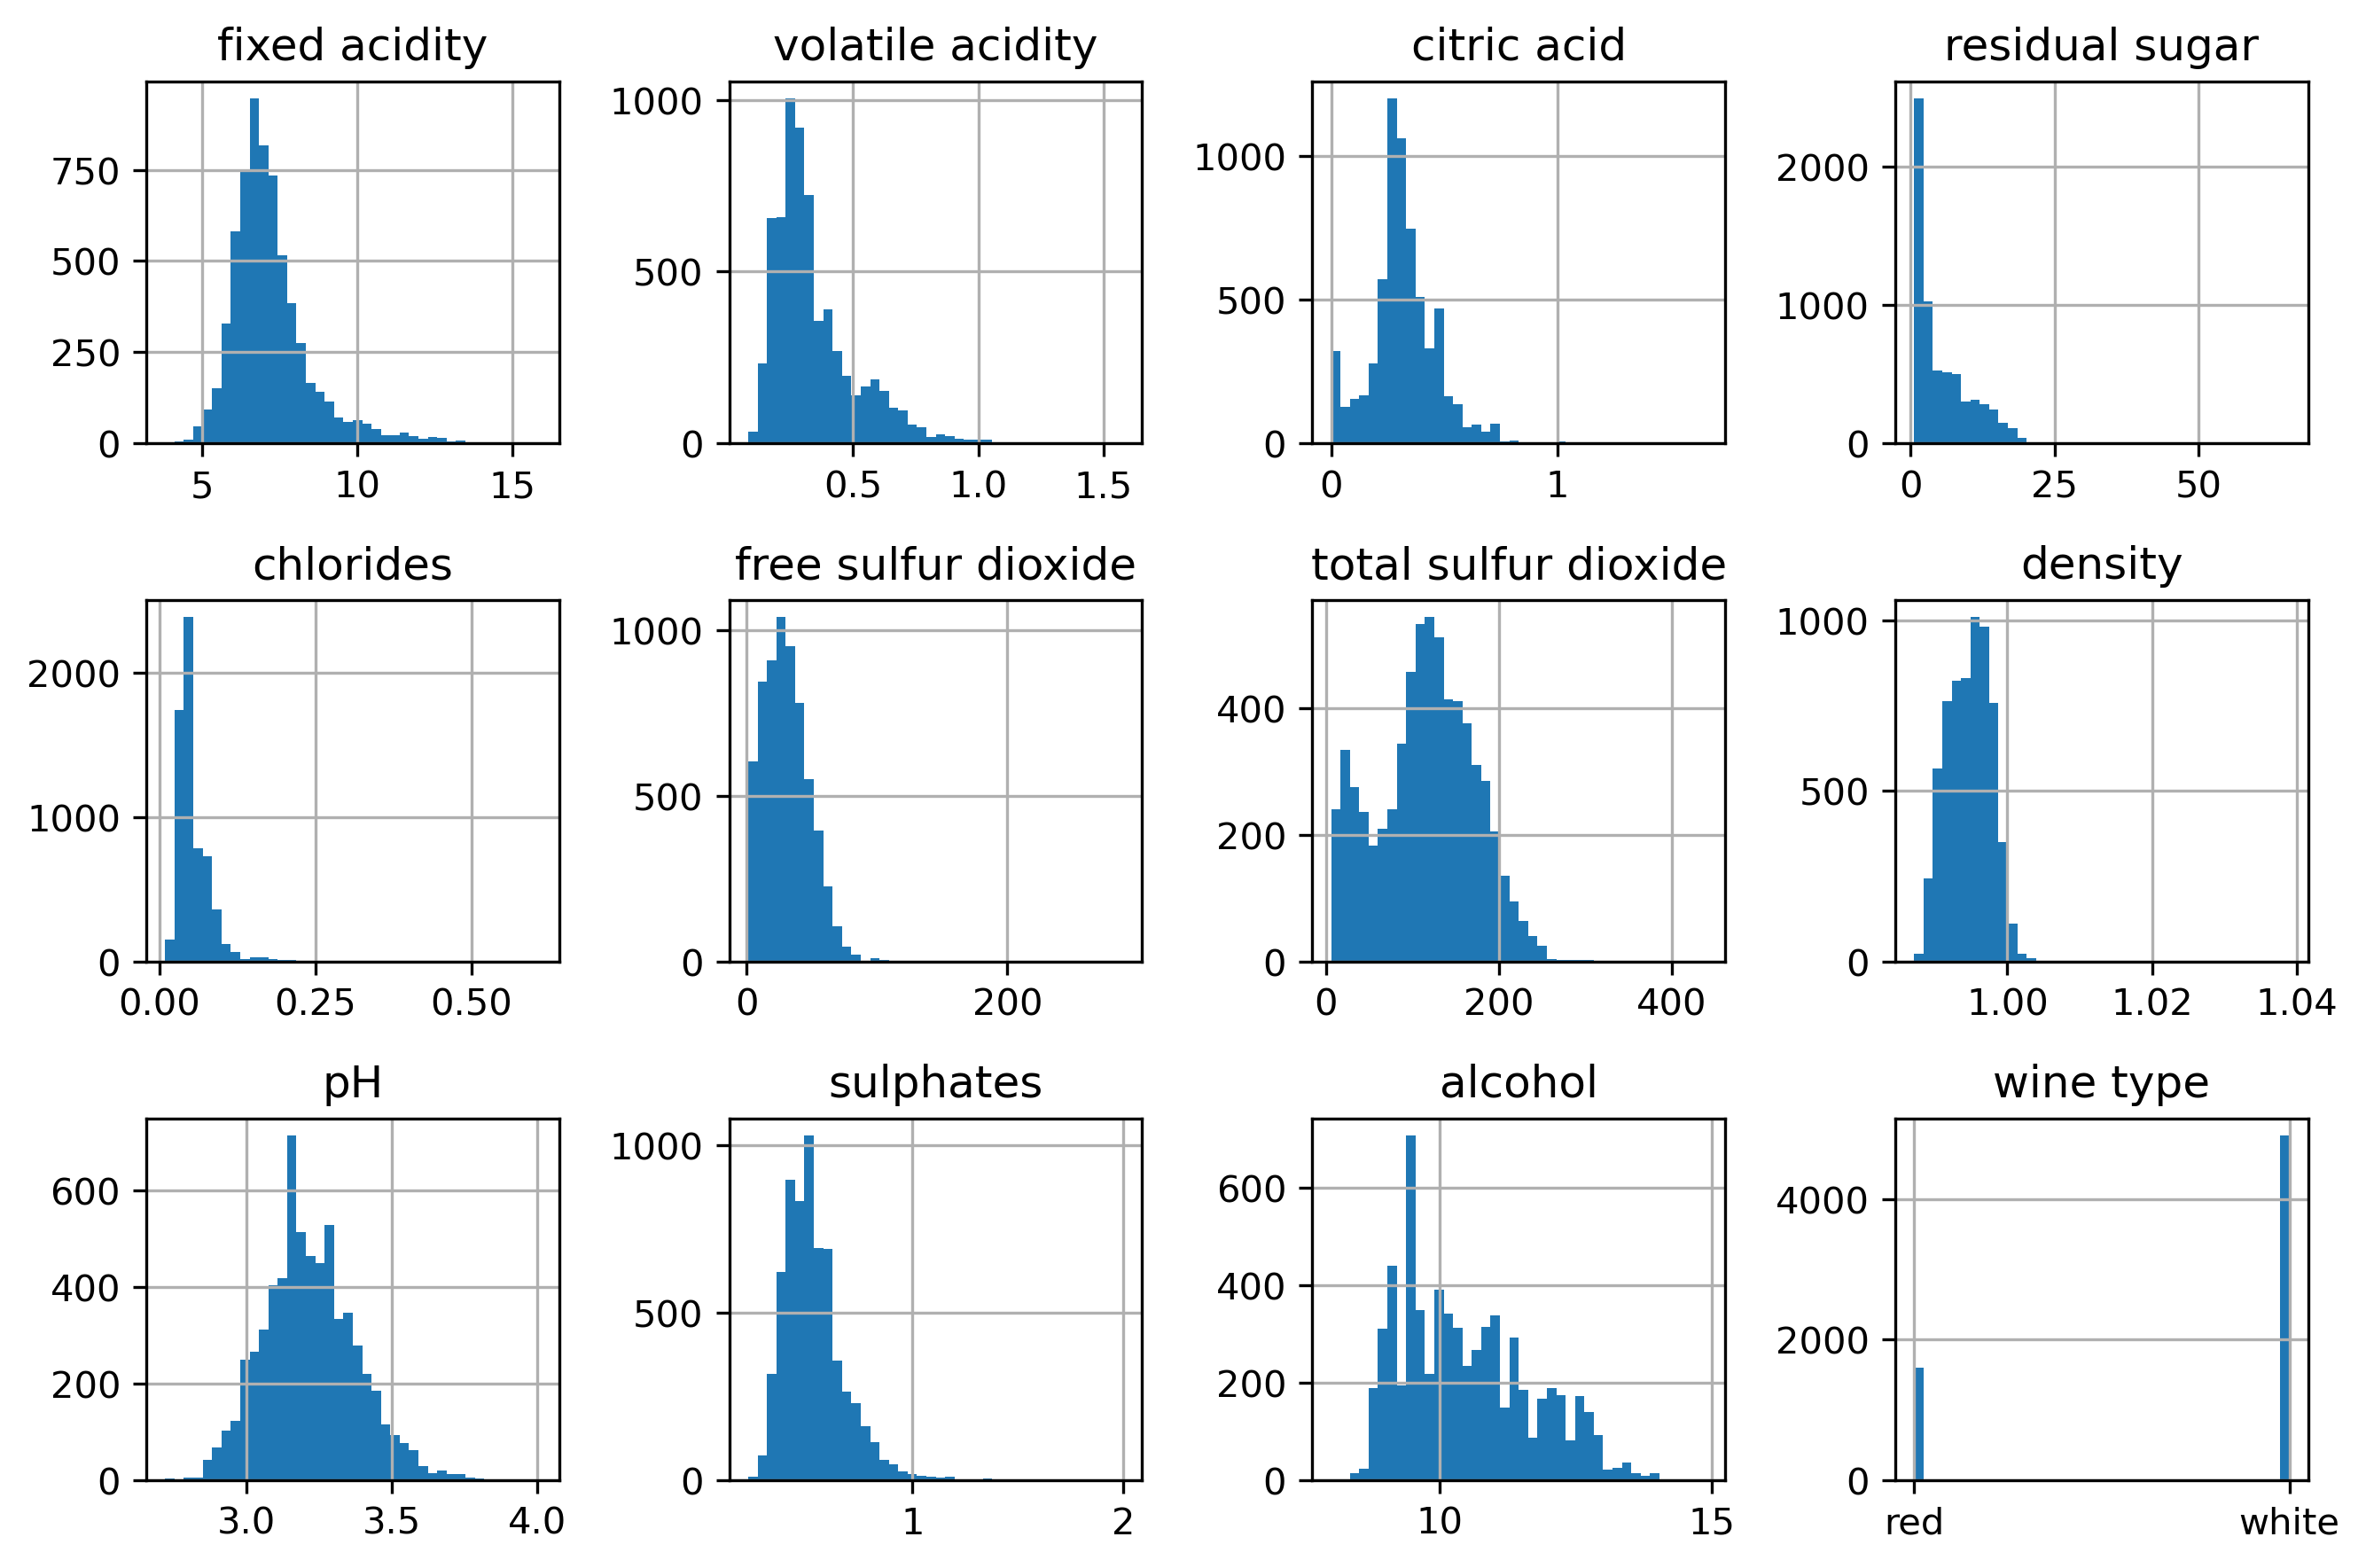

In [10]:
# Check shape of each input variable's distribution
fig = plt.figure(dpi=300, figsize = (9,6)) # initialize grid of histograms

for i, var_name in enumerate([col for col in df.columns if col!='quality']):
    ax = fig.add_subplot(3, 4, i+1)
    df[var_name].hist(bins=40, ax=ax)
    ax.set_title(var_name)

fig.tight_layout()  # improves appearance
plt.show()

In [11]:
print(f'Numerical distribution of wine quality: {Counter(df.quality).most_common()}')

Numerical distribution of wine quality: [(6, 2836), (5, 2138), (7, 1079), (4, 216), (8, 193), (3, 30), (9, 5)]


<AxesSubplot:>

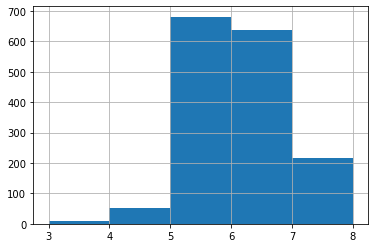

In [12]:
# Check shape of output variable's distribution for each wine type
qual_range = df[df['wine type']=='red'].quality.max() - df[df['wine type']=='red'].quality.min()
df[df['wine type']=='red'].quality.hist(bins=qual_range)

<AxesSubplot:>

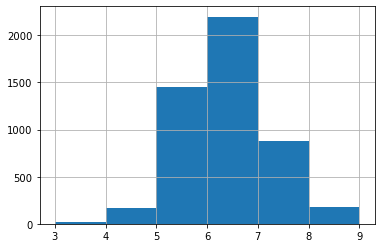

In [13]:
qual_range = df[df['wine type']=='white'].quality.max() - df[df['wine type']=='white'].quality.min()
df[df['wine type']=='white'].quality.hist(bins=qual_range)

In [313]:
print('Attributes of quality for each wine type:')
df.groupby('wine type').agg({'quality':['min', np.mean, np.median, 'max']})

Attributes of quality for each wine type:


quality                     
              min      mean median max
wine type                             
red             3  5.636023    6.0   8
white           3  5.877909    6.0   9

In [314]:
print('Other average attributes for each wine type:')
df.groupby('wine type').agg(np.mean)

print('Standard deviation of other attributes for each wine type:')
df.groupby('wine type').agg(np.std)

Other average attributes for each wine type:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
wine type,,,,,,,,,,,,
red,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
white,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909


Standard deviation of other attributes for each wine type:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
wine type,,,,,,,,,,,,
red,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
white,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639


In [325]:
# STANDARDIZE X so it has a mean of zero and variance scaling
df['red'] = df['wine type'].map({'red':1, 'white':0}) # turn into binary variable so we can standardize it
df.drop(columns=['wine type'], inplace=True) # drop original

scaler = StandardScaler(); scaler.fit(df)
df_std = scaler.transform(df)
df_std = pd.DataFrame(df_std, columns=df.columns)
df_std.groupby('red').agg(np.mean).reset_index().sort_values(by='red', ascending=False).drop(columns='red')
# Note: Red wine is the top row here, same as previous tables

StandardScaler()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,0.851887,1.142936,-0.327979,-0.610503,0.897284,-0.825466,-1.225758,0.683703,0.576038,0.852724,-0.057703,-0.208838
0,-0.278107,-0.373123,0.107072,0.199305,-0.292927,0.269481,0.400161,-0.223202,-0.188053,-0.278380,0.018838,0.068177


<b>Interpretation:</b> These data look quite clean! There are no missing values, and most of the variables have normal distributions and no apparent outliers. As for comparing the wine types, red wines have higher fixed and volatile acidity and sulfates, but lower pH and less alcohol, sugar, sulfur, and citric acid. Most importantly, white wine has higher quality on average, though the difference is only about a third of a standard deviation.

### Create arrays for features (X) and outcome variable (y)

In [333]:
test_size = 0.2
seed = 3

# set outcome/response variable
y = df.quality
y = y.astype('float')

# set features/predictors, keep outcome intact for now for evaluation purposes
X = df.copy() 

# Do a train/test split, separating 20% of the entire dataset for prediction purposes (X_test, Y_test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=seed
)

# normalize X so it shares a standard 0-1 scale, 
# drop outcome column for prediction purposes (but keep in X for inspection after)
scaler = MinMaxScaler(); scaler.fit(X.drop(columns=['quality']))
X_norm = scaler.transform(X.drop(columns=['quality']))
X_train_norm = scaler.transform(X_train.drop(columns=['quality']))
X_test_norm = scaler.transform(X_test.drop(columns=['quality']))

print('Distribution of raw quality scores:')
print(Counter(y_train).most_common())
print()

print('Statistics for features in TRAINING data:')
pd.DataFrame(X_train, columns=df.columns).describe()
print()

print('Statistics for features in TEST data:')
pd.DataFrame(X_test, columns=df.columns).describe()

MinMaxScaler()

Distribution of raw quality scores:
[(6.0, 2272), (5.0, 1704), (7.0, 865), (4.0, 174), (8.0, 154), (3.0, 25), (9.0, 3)]

Statistics for features in TRAINING data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
count,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.221522,0.339144,0.318738,5.456542,0.055520,30.653069,116.009044,0.994701,3.217818,0.531655,10.493351,0.243794
std,1.314951,0.165422,0.144708,4.740825,0.033969,17.988414,56.638330,0.002991,0.160929,0.148182,1.184731,0.429411
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.500000,0.992380,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994860,3.210000,0.510000,10.300000,0.000000
75%,7.700000,0.400000,0.390000,8.150000,0.064000,42.000000,156.000000,0.996960,3.320000,0.600000,11.300000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000



Statistics for features in TEST data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.190462,0.341754,0.318215,5.390038,0.058090,30.014615,114.687308,0.994678,3.221231,0.529723,10.485603,0.255385
std,1.219770,0.161502,0.147786,4.826562,0.038945,16.756790,56.062995,0.003029,0.160251,0.151324,1.224543,0.436245
min,3.900000,0.080000,0.000000,0.700000,0.009000,3.000000,6.000000,0.987220,2.770000,0.230000,8.400000,0.000000
25%,6.400000,0.220000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992237,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.300000,0.310000,2.800000,0.048000,29.000000,117.000000,0.995000,3.210000,0.500000,10.300000,0.000000
75%,7.700000,0.410000,0.390000,7.900000,0.069000,41.000000,154.000000,0.997000,3.320000,0.600000,11.300000,1.000000
max,14.300000,1.090000,1.230000,31.600000,0.415000,128.000000,303.000000,1.010300,4.010000,1.980000,14.000000,1.000000


### Visualize feature space to see possible clusters

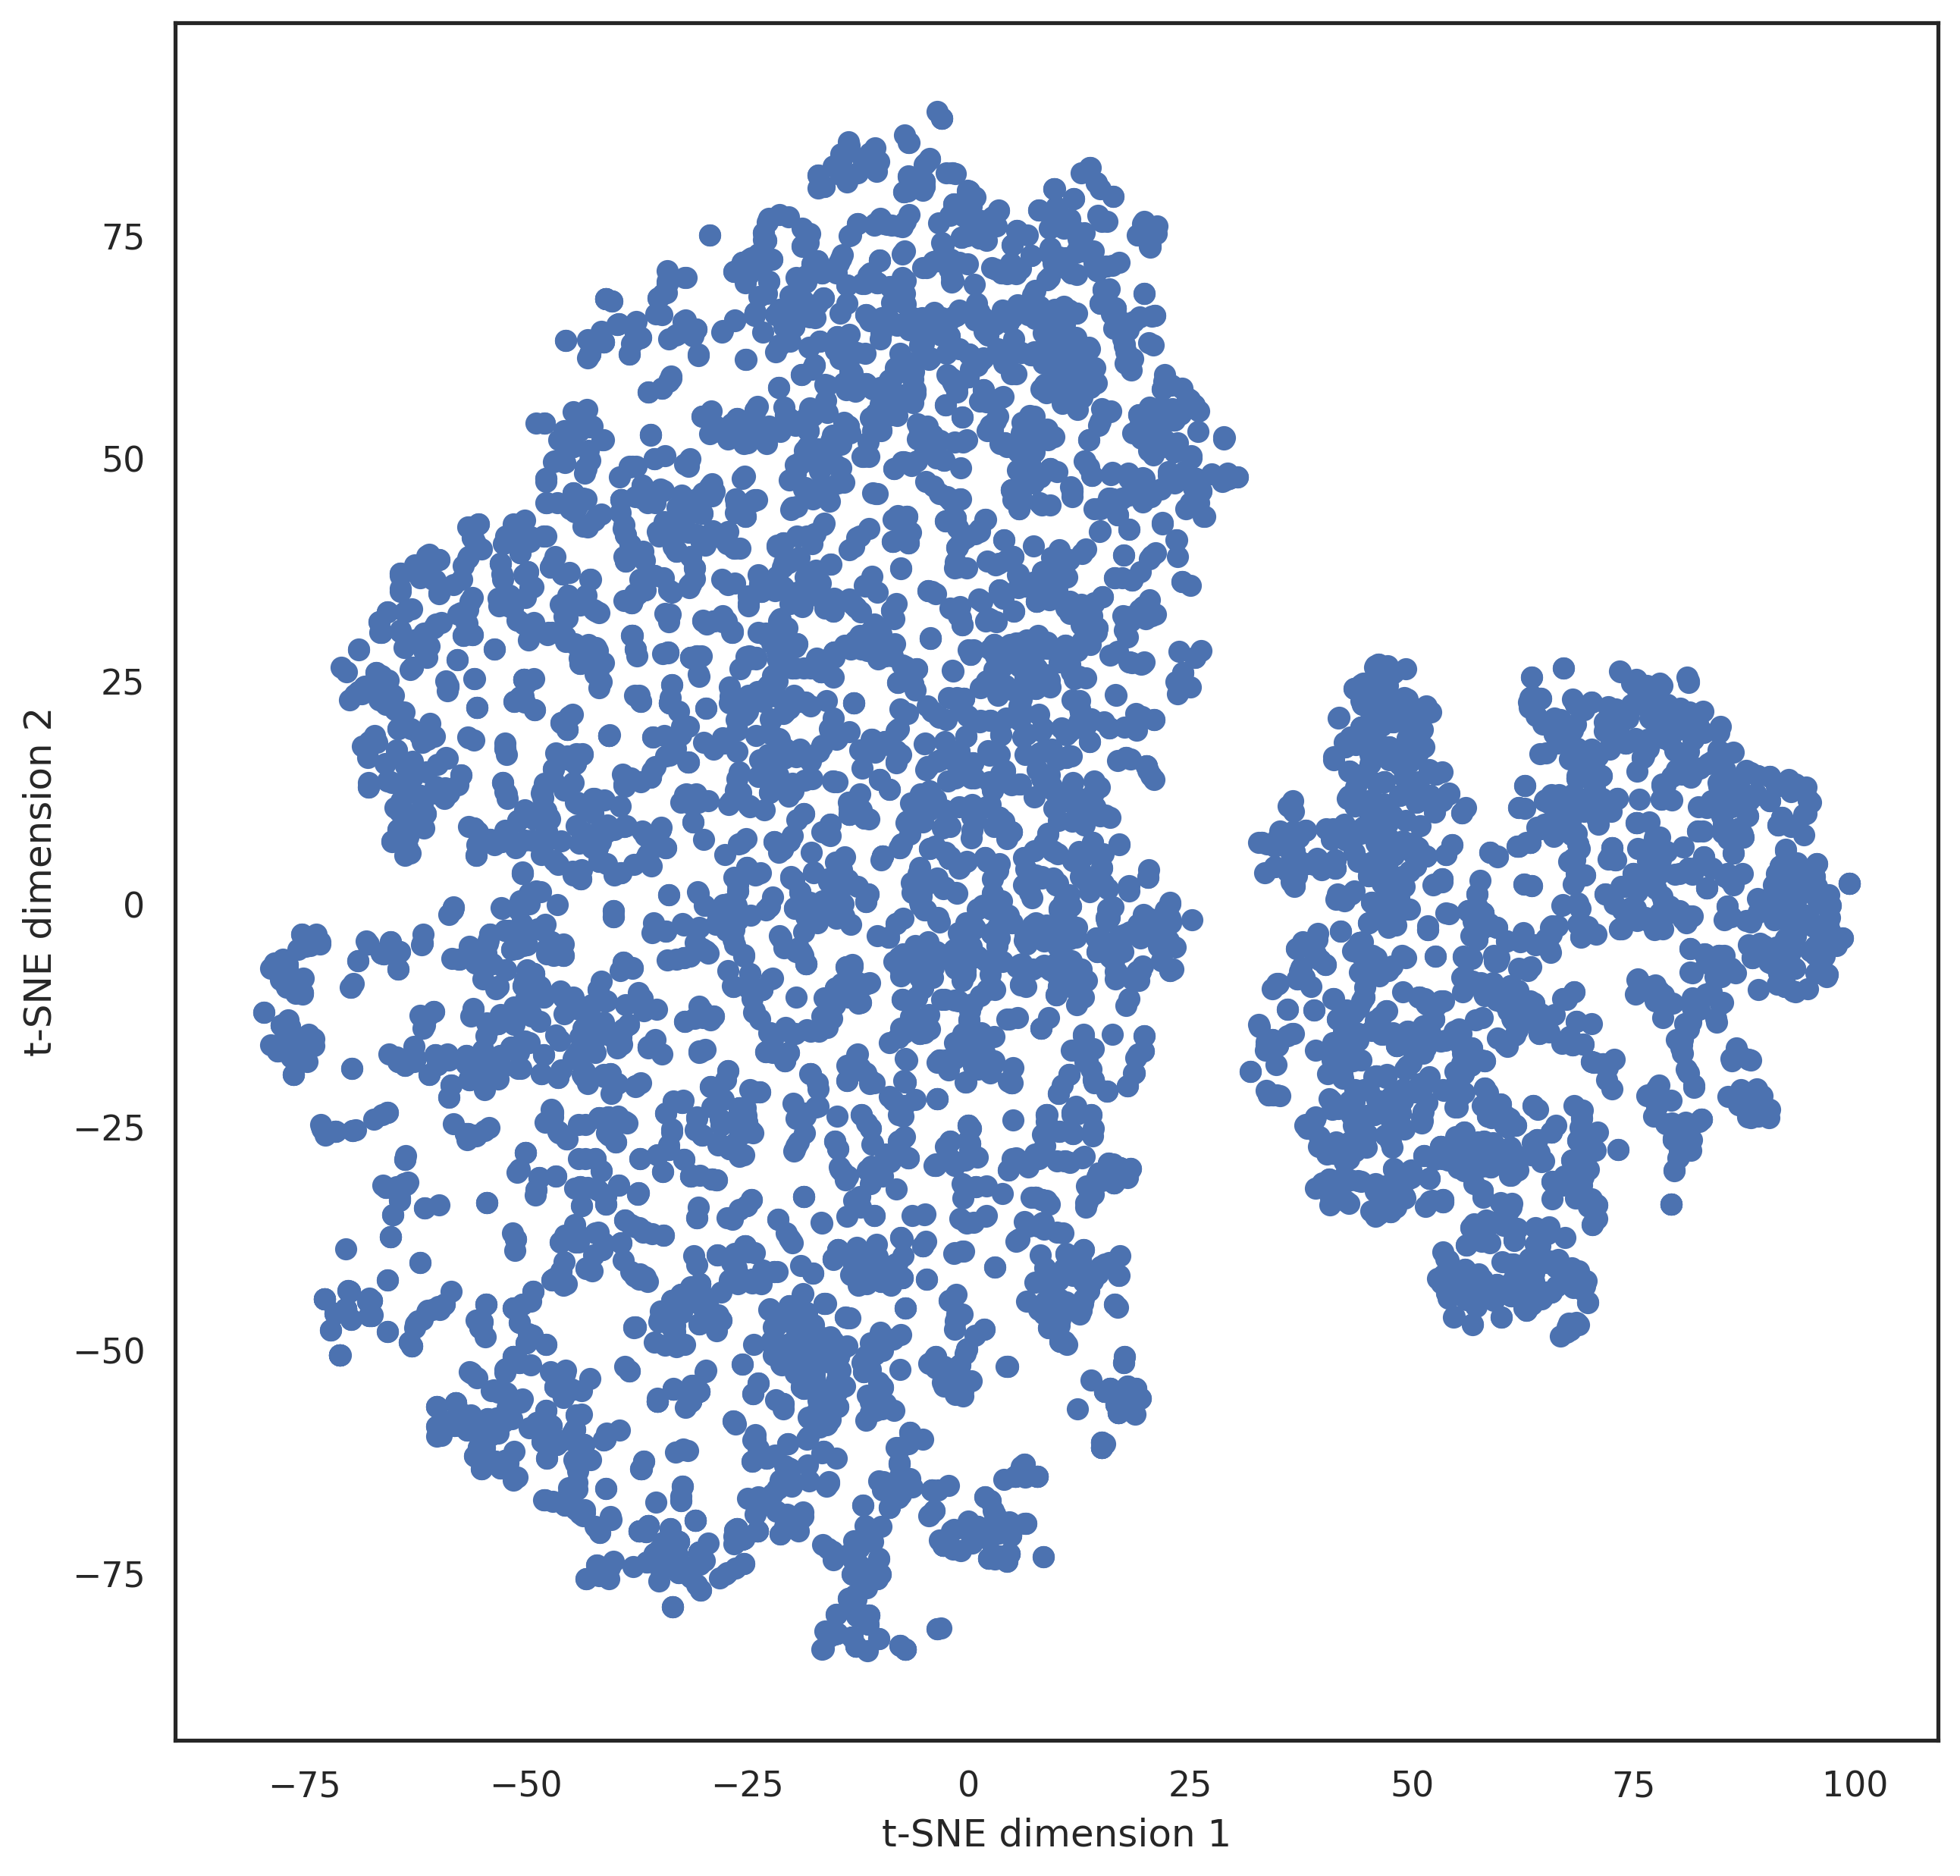

In [117]:
# find tsne coords for 2 dimensions using euclidean distances
tsne = TSNE(n_components=2, 
            metric='euclidean',
            random_state=seed)
np.set_printoptions(suppress=True)

pos = tsne.fit_transform(X)
x_coords, y_coords = pos[:, 0], pos[:, 1]

# display scatter plot
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.scatter(x_coords, y_coords, alpha=1, color='b')

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.xlim(x_coords.min()-10, x_coords.max()+10)
plt.ylim(y_coords.min()-10, y_coords.max()+10)
plt.show()

## Clustering on full dataset

### Hierarchical clustering

dendro_right
cluster threshold: 36.413569072572194


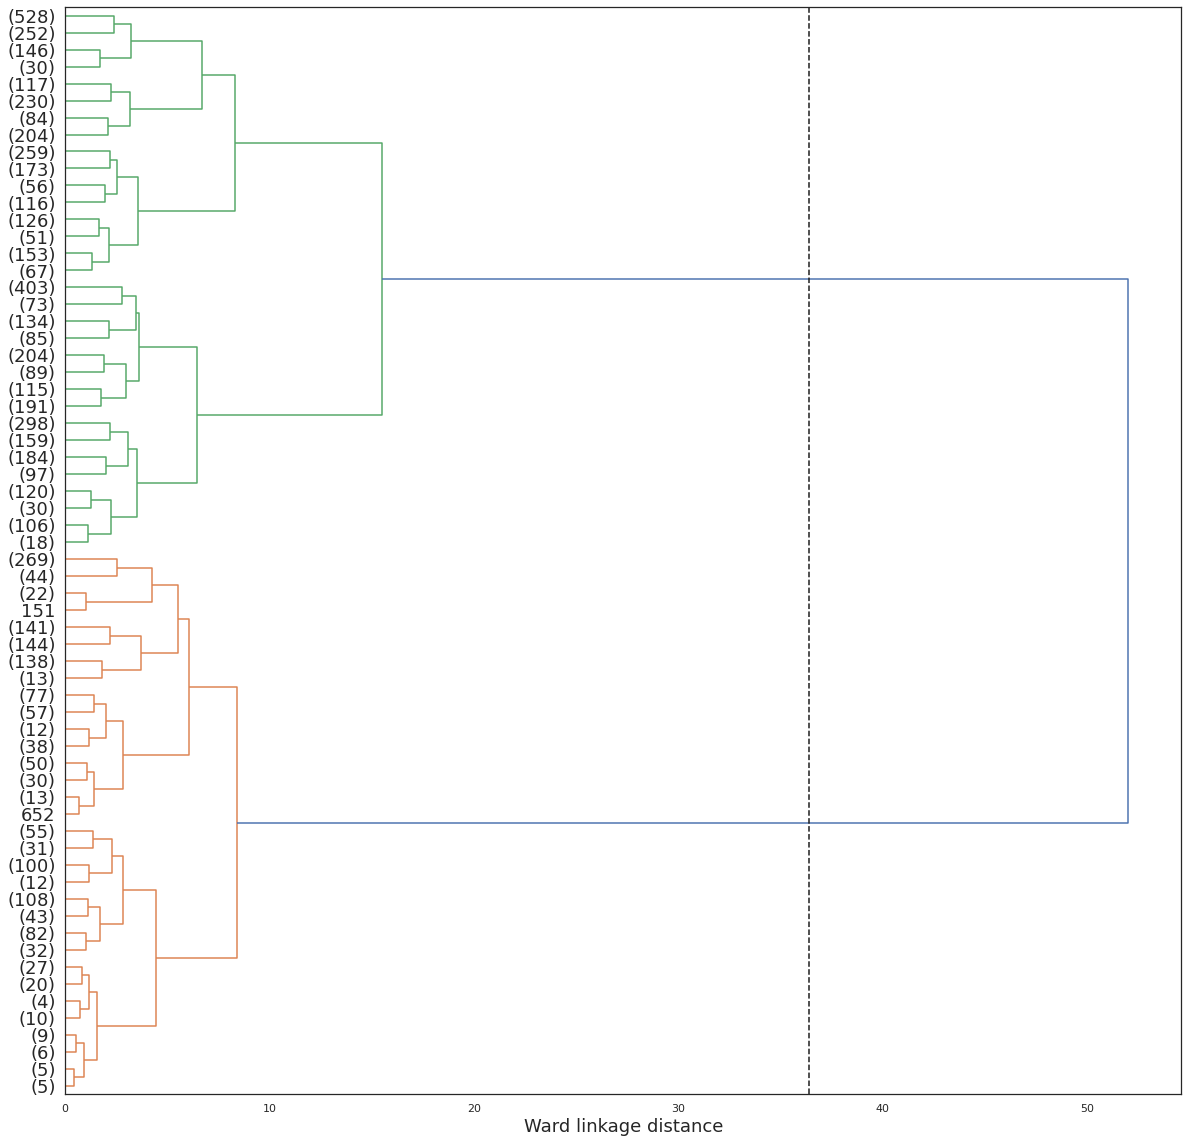

Saved dendrogram!


In [213]:
## Prepare and save dendrogram
orientation = 'right' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram
models_dir = '../models/'
output_dir = '../output/'

hierarchical = make_dendrogram(X_norm, y,
                               linkage = 'ward',
                               metric = 'euclidean', 
                               n_clusters=None,
                               distance_threshold=0,
                               levels=5,
                               orientation = orientation,
                               save_plot = True, 
                               fontsize = 18)
    
print("Saved dendrogram!")

<b>Interpretation:</b> We see two clear clusters both from tSNE and hierarchical clustering. Could this have something to do with wine type, as one might expect from a naive clustering attempt? Let's do a simpler k-means clustering to explore. 

### KMeans with two naive clusters

In [338]:
km = KMeans(n_clusters=2,
            algorithm='lloyd',
            init='random',
            n_init='auto',
            random_state=seed)

km_model = km.fit(X_train_norm) # fit on training data
print('Length of k-means clustering output:', str(len(km_model.labels_)))
km_model.labels_

Length of k-means clustering output: 5197


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [339]:
# Examine cluster assignment with training data
result_train = X_train.copy()
result_train['cluster'] = km_model.labels_

result_train.groupby(['red', 'cluster']).agg('mean')

,,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
red,cluster,,,,,,,,,,,,
0,1,6.857061,0.277912,0.334298,6.399860,0.045492,35.457506,138.617684,0.994035,3.187784,0.490751,10.512149,5.876590
1,0,8.352013,0.529073,0.270474,2.530545,0.086623,15.750592,45.881215,0.996767,3.310979,0.658532,10.435043,5.636938


In [224]:
# Examine cluster assignment with test data
result_test = X_test.copy()
predictions = km_model.predict(X_test_norm) # predict clusters for test data using trained kmeans model
result_test['cluster'] = predictions

result_test.groupby(['red', 'cluster']).agg('mean')

,,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
red,cluster,,,,,,,,,,,
0,1,6.845558,0.279576,0.333760,6.357128,0.046910,34.701446,137.317149,0.993995,3.190227,0.486178,10.522865
1,0,8.196084,0.523042,0.272892,2.570331,0.090687,16.349398,48.706325,0.996671,3.311627,0.656687,10.376958


<b>Interpretation:</b> The naive kmeans model with two clusters predicts cluster assignment perfectly. There is one cluster for red wines and another for white wines, with the same notable characteristics observed earlier (red has higher acidity, less alcohol and sugar, etc.). So this clustering approach seems to do a great job pulling out the main qualities of each wine type. 

Let's now apply this same method to each wine type separately to pull out sub-categories. 

## Clustering within wine type

### Prepare arrays of features and outcome

In [275]:
# Do another train/test split using 20%, this time separated by wine type (red/white)
df_red, df_white = df[df['wine type']=='red'], df[df['wine type']=='white']

# set outcome/response variable
y_red, y_white = df_red.quality, df_white.quality
y_red, y_white = y_red.astype('float'), y_white.astype('float')

# set features/predictors, keep outcome intact for now for evaluation purposes
X_red, X_white = df_red.copy(), df_white.copy()
X_red['red'] = X_red['wine type'].map({'red':1, 'white':0})
X_red.drop(columns=['wine type'], inplace=True)
X_white['red'] = X_white['wine type'].map({'red':1, 'white':0})
X_white.drop(columns=['wine type'], inplace=True)

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y_red, test_size=test_size, random_state=seed)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(
    X_white, y_white, test_size=test_size, random_state=seed)


# NORMALIZE X so it shares a standard 0-1 scale, drop outcome column
scaler_red = MinMaxScaler(); scaler_red.fit(X_red.drop(columns=['quality']))
X_red_norm = scaler_red.transform(X_red.drop(columns=['quality']))
X_red_train_norm = scaler_red.transform(X_red_train.drop(columns=['quality']))
X_red_test_norm = scaler_red.transform(X_red_test.drop(columns=['quality']))

# repeat for white wine cases
scaler_white = MinMaxScaler(); scaler_white.fit(X_white.drop(columns=['quality']))
X_white_norm = scaler_red.transform(X_white.drop(columns=['quality']))
X_white_train_norm = scaler_white.transform(X_white_train.drop(columns=['quality']))
X_white_test_norm = scaler_white.transform(X_white_test.drop(columns=['quality']))


# STANDARDIZE X so it has a mean of zero and variance scaling
scaler_red = StandardScaler(); scaler_red.fit(X_red.drop(columns=['quality']))
X_red_std = scaler_red.transform(X_red.drop(columns=['quality']))
X_red_train_std = scaler_red.transform(X_red_train.drop(columns=['quality']))
X_red_test_std = scaler_red.transform(X_red_test.drop(columns=['quality']))

# repeat for white wine cases
scaler_white = StandardScaler(); scaler_white.fit(X_white.drop(columns=['quality']))
X_white_std = scaler_red.transform(X_white.drop(columns=['quality']))
X_white_train_std = scaler_white.transform(X_white_train.drop(columns=['quality']))
X_white_test_std = scaler_white.transform(X_white_test.drop(columns=['quality']))

MinMaxScaler()

MinMaxScaler()

StandardScaler()

StandardScaler()

### Cluster red wine features

#### Visualize feature space for clusters for red wines

Text(0.5, 0, 't-SNE dimension 1')

Text(0, 0.5, 't-SNE dimension 2')

(-62.522064208984375, 80.56666564941406)

(-55.57909393310547, 46.288787841796875)

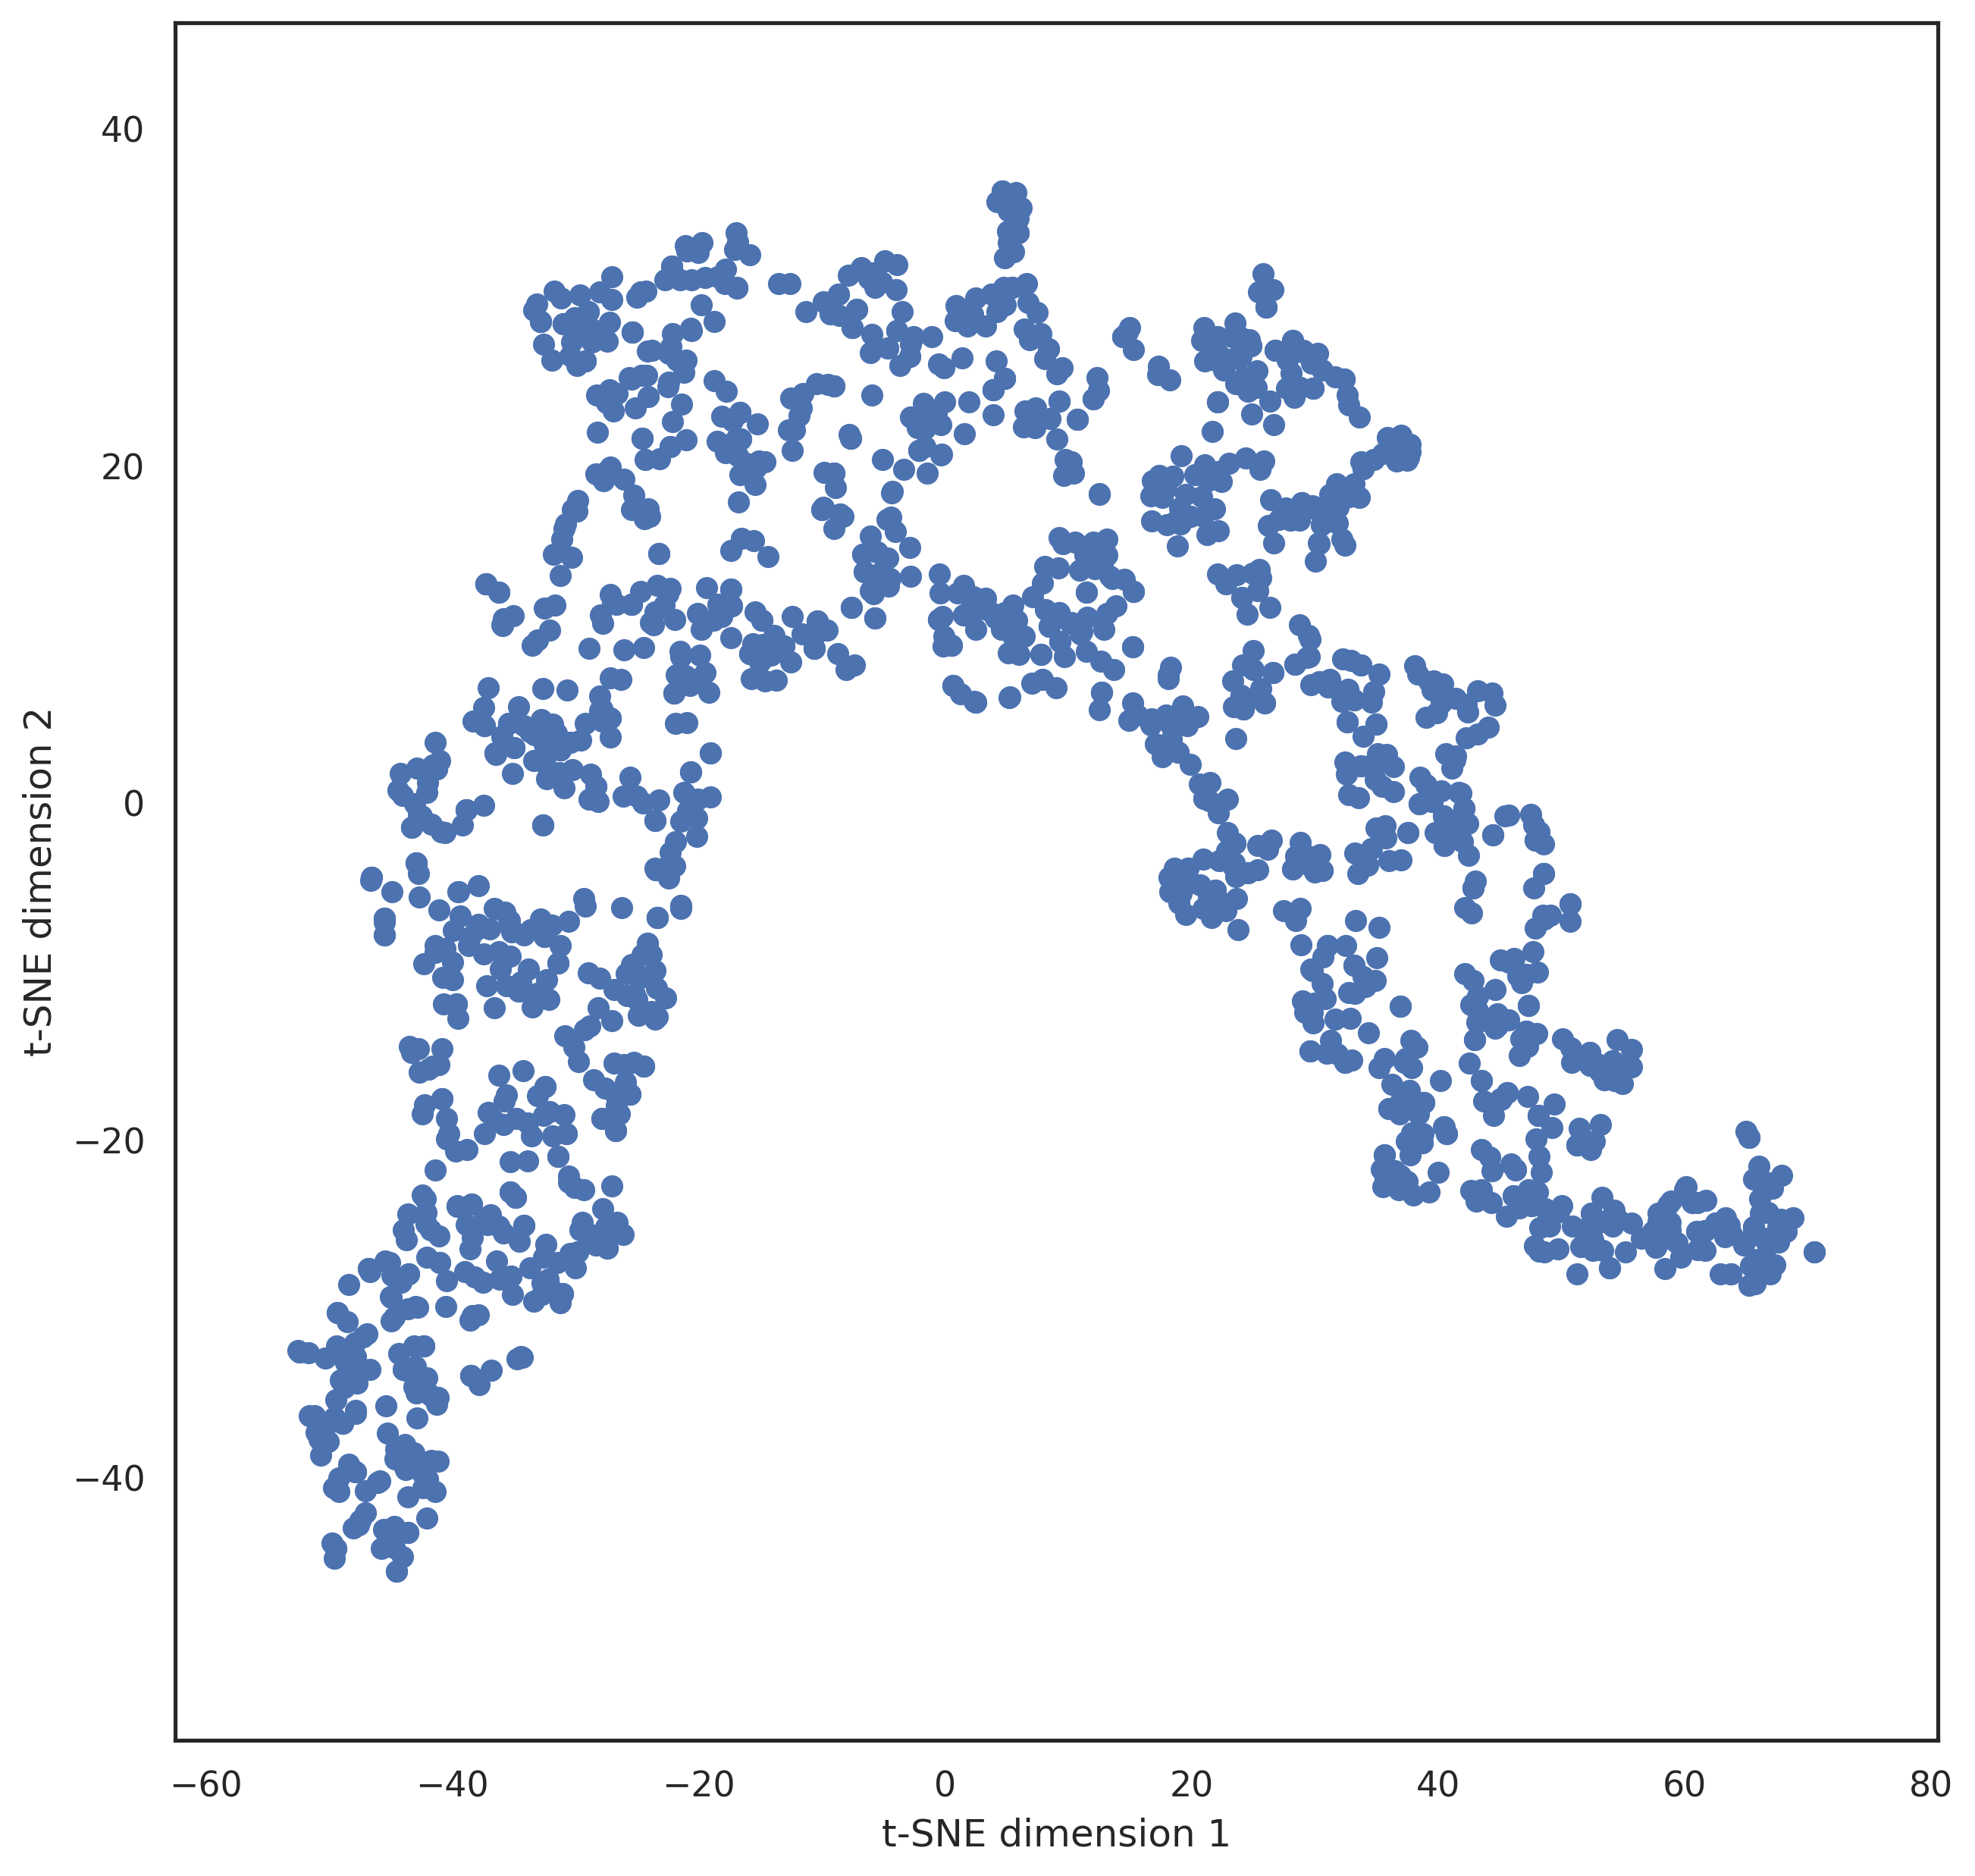

In [237]:
# RED: Visualize feature space using t-SNE in 2 dimensions and Euclidean distances
tsne_red = TSNE(n_components=2, 
                metric='euclidean',
                random_state=seed)

pos = tsne_red.fit_transform(X_red)
x_coords, y_coords = pos[:, 0], pos[:, 1]

# display scatter plot
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.scatter(x_coords, y_coords, alpha=1, color='b')

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.xlim(x_coords.min()-10, x_coords.max()+10)
plt.ylim(y_coords.min()-10, y_coords.max()+10)
plt.show()

dendro_right
cluster threshold: 8.244783095033823


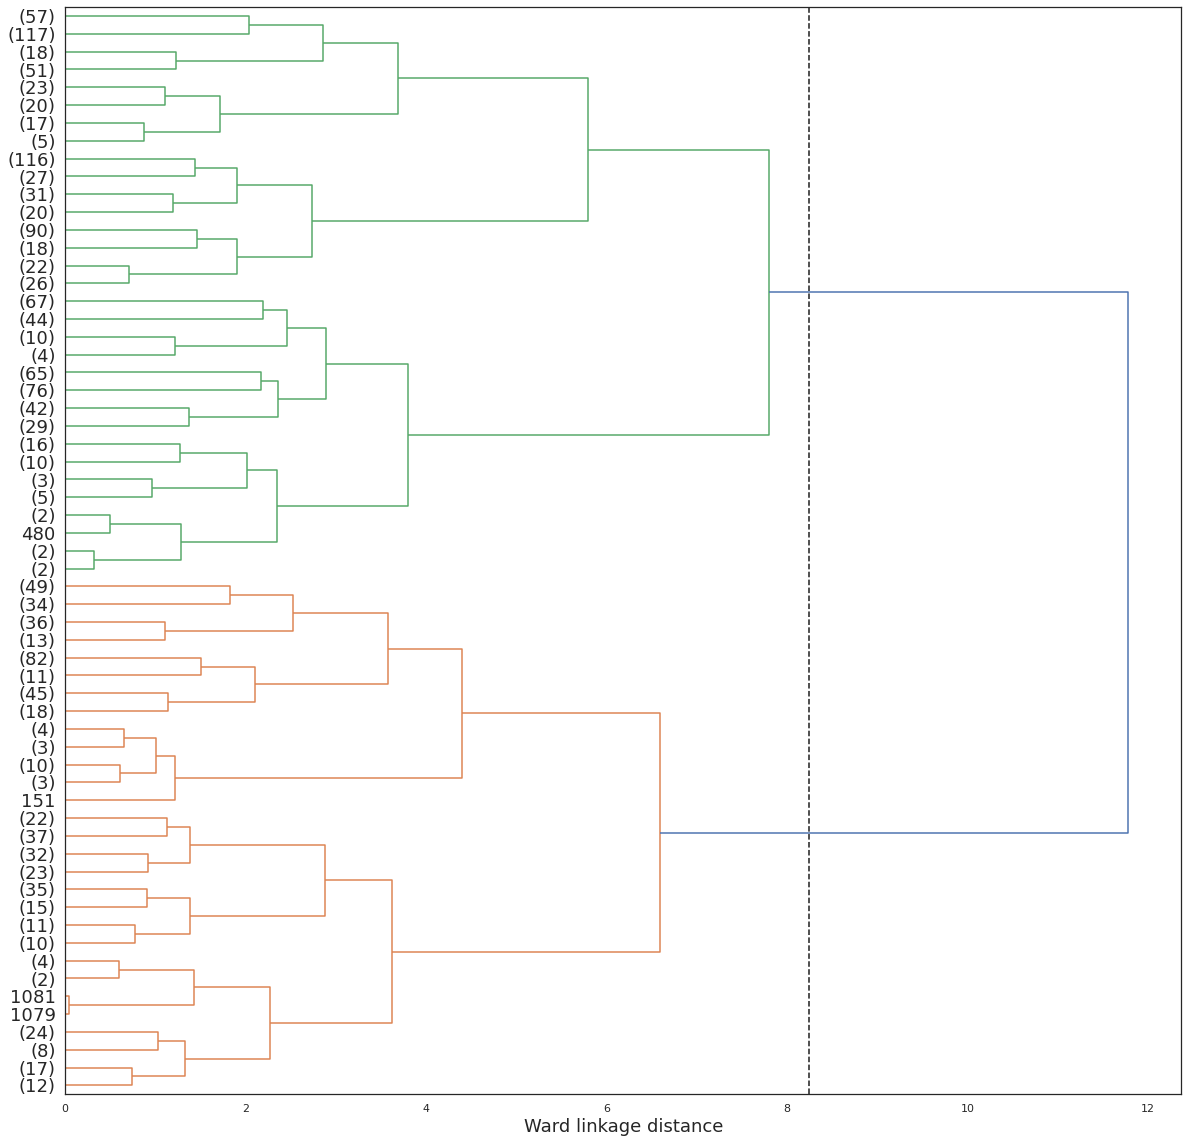

Saved dendrogram!


In [244]:
## RED: Do hierarchical clustering and display dendrogram
orientation = 'right' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram
models_dir = '../models/'
output_dir = '../output/'

hierarchical = make_dendrogram(X_red_norm, y_red,
                               linkage = 'ward',
                               metric = 'euclidean', 
                               n_clusters=None,
                               distance_threshold=0,
                               levels=5,
                               orientation = orientation,
                               save_plot = True, 
                               fontsize = 18)
    
print("Saved dendrogram!")

In [277]:
# RED: KMeans clustering with two clusters
km_red = KMeans(n_clusters=2,
                algorithm='lloyd',
                init='random',
                n_init='auto',
                random_state=seed)

km_model_red = km.fit(X_red_train_norm) # fit on training data
print('Length of k-means clustering output for training data:', str(len(km_model_red.labels_)))
print()


# Examine cluster assignment with training data
result_train_red = pd.DataFrame(X_red_train.copy(), columns=X_red.columns)
result_train_red['cluster'] = km_model_red.labels_

print("Cluster features in training data set:")
result_train_red.groupby('cluster').agg('mean')

# Examine cluster assignment with test data
result_test_red = X_red_test.copy()
predictions = km_model_red.predict(X_red_test_norm) # predict clusters for test data using trained kmeans model
result_test_red['cluster'] = predictions

print("Cluster features in test data set:")
result_test_red.groupby('cluster').agg('mean')


# Examine cluster assignment with STANDARDIZED test data
result_test_red_std = pd.DataFrame(X_red_test_std.copy(), columns=[col for col in X_red.columns if col!='quality'])
predictions = km_model_red.predict(X_red_test_norm) # predict clusters for test data using trained kmeans model
result_test_red_std['cluster'] = predictions

print("Cluster features in STANDARDIZED test data set (without quality):")
result_test_red_std.groupby('cluster').agg('mean')

Length of k-means clustering output for training data: 1279

Cluster features in training data set:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
cluster,,,,,,,,,,,,,
0,7.371373,0.606902,0.142549,2.397320,0.080824,16.626144,49.620915,0.996277,3.375699,0.604641,10.247146,5.449673,1.0
1,9.824319,0.407510,0.465700,2.706031,0.095440,14.377432,41.346304,0.997494,3.213132,0.737004,10.701686,5.939689,1.0


Cluster features in test data set:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
cluster,,,,,,,,,,,,,
0,7.307653,0.603724,0.143929,2.485204,0.084536,17.750000,49.448980,0.996132,3.369643,0.610816,10.329677,5.469388,1.0
1,9.532258,0.418669,0.456935,2.803226,0.100032,14.483871,43.532258,0.997522,3.226290,0.736210,10.500000,5.790323,1.0


Cluster features in STANDARDIZED test data set (without quality):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
cluster,,,,,,,,,,,,
0,-0.581416,0.424036,-0.652392,-0.038029,-0.062291,0.179315,0.090655,-0.325713,0.379230,-0.279324,-0.087584,0.0
1,0.696688,-0.609770,0.954913,0.187600,0.267068,-0.133027,-0.089267,0.410683,-0.549591,0.460661,0.072294,0.0


<b>Interpretation:</b> <br>
Kmeans clustering on red wines with two clusters shows a higher-quality cluster, though the difference is around one third of a standard deviation. The following features appear most significant, i.e. greater than one standard deviation of difference between the clusters:
* higher fixed acidity (in the higher-quality cluster)
* lower volatile acidity 
* higher citric acid 

The following features of the higher-quality cluster are also somewhat significant (close to but less than one standard deviation of difference):
* higher density
* lower pH
* higher sulphates

Recall that white wines similarly have (somewhat) higher citric acid, lower volatile (though fixed acidity runs the other way), (somewhat) lower density, and lower sulphates. In other words, many of the distinguishing characteristics of white wine are also those characteristics that distinguish red wine that people like better (higher sensory preference/quality). This suggests that these properties--most importantly, lower overall acidity and lower sulphates--_in conjunction_ are among the most important predictors of wine quality overall.

Let's now do the same clustering-based comparison of features for white wines.

### Cluster white wine features

#### Visualize possible clusters for white wines

Text(0.5, 0, 't-SNE dimension 1')

Text(0, 0.5, 't-SNE dimension 2')

(-125.04011535644531, 116.5126724243164)

(-57.5086669921875, 57.970035552978516)

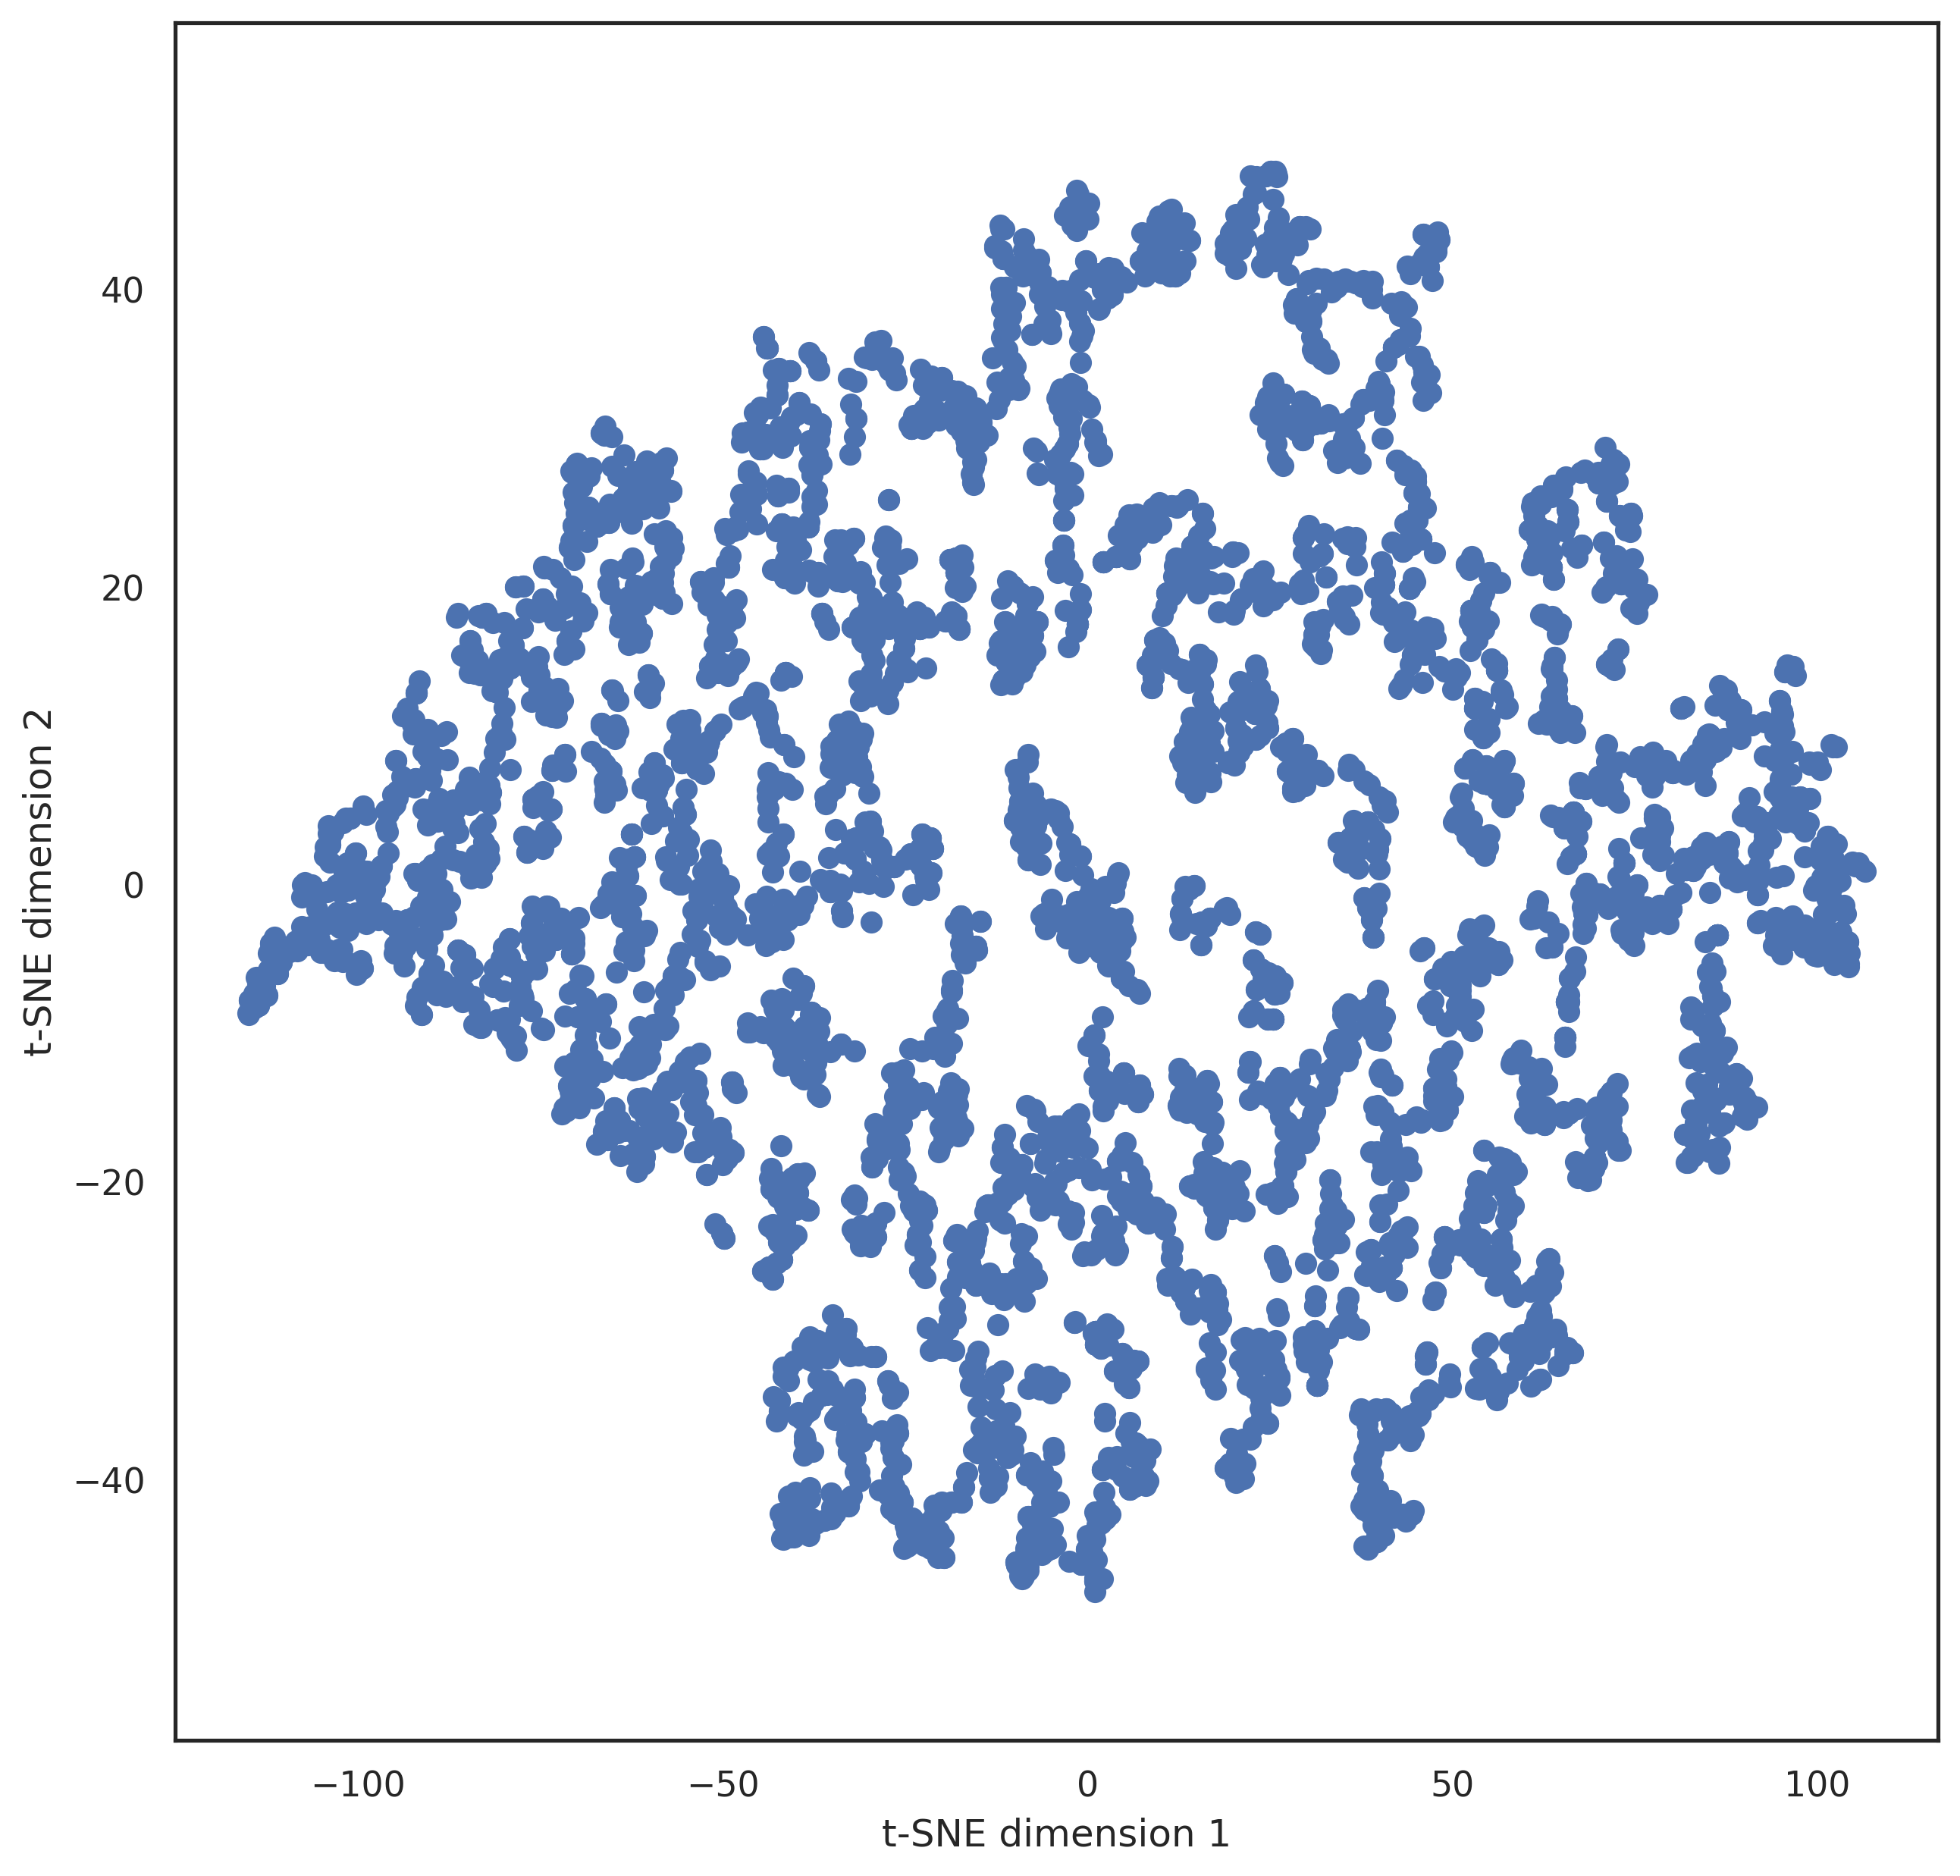

In [238]:
## WHITE: Visualize feature space using t-SNE in 2 dimensions and Euclidean distances
tsne_white = TSNE(n_components=2, 
                  metric='euclidean',
                  random_state=seed)

pos = tsne_white.fit_transform(X_white)
x_coords, y_coords = pos[:, 0], pos[:, 1]

# display scatter plot
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.scatter(x_coords, y_coords, alpha=1, color='b')

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.xlim(x_coords.min()-10, x_coords.max()+10)
plt.ylim(y_coords.min()-10, y_coords.max()+10)
plt.show()

dendro_right
cluster threshold: 23.157964466158862


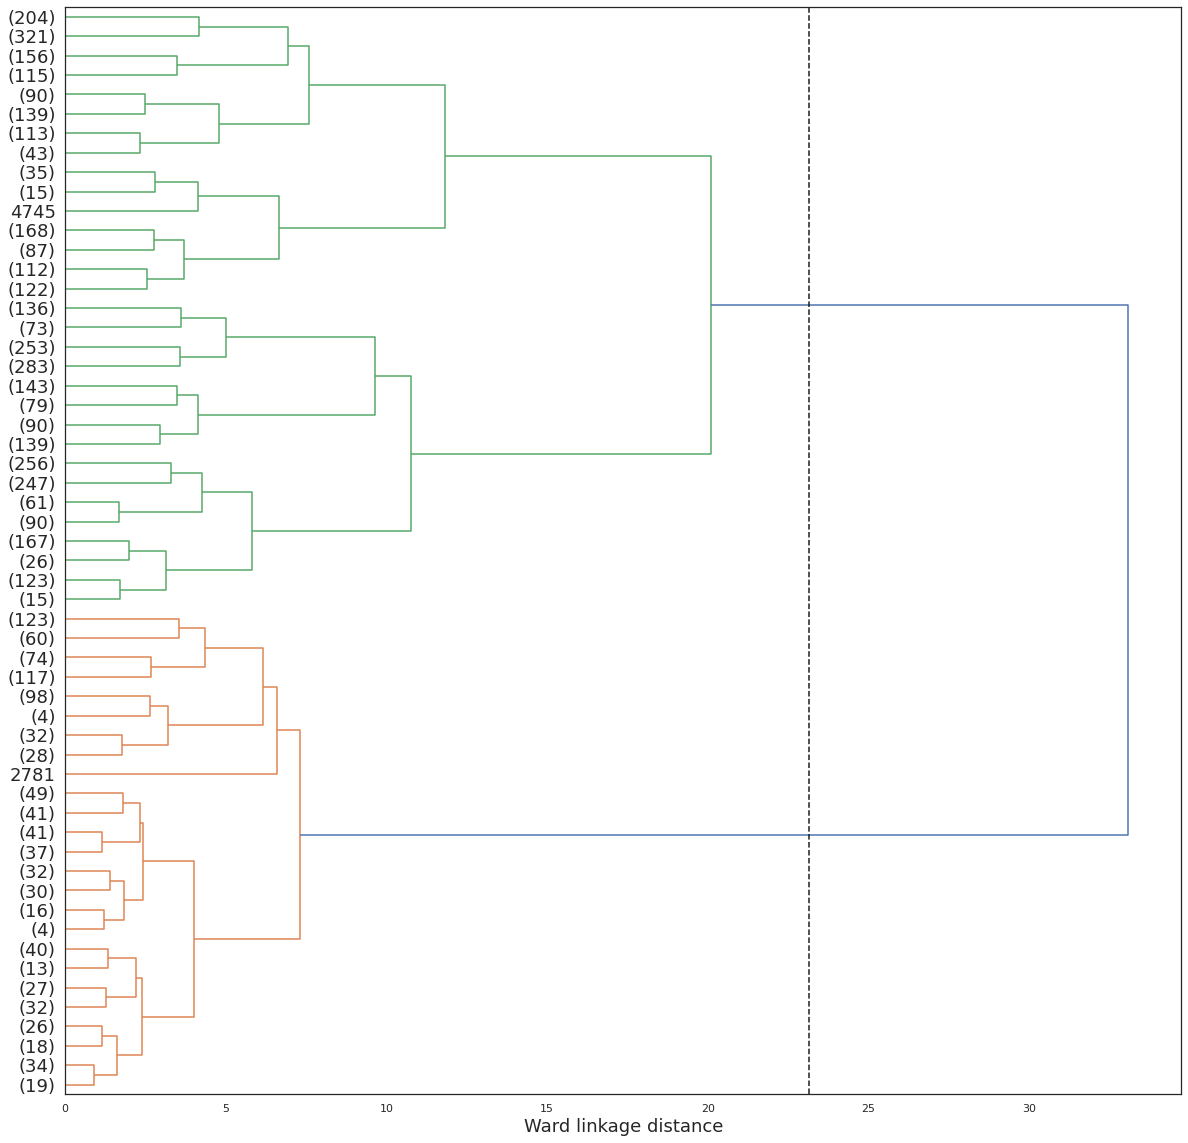

Saved dendrogram!


In [252]:
## WHITE: Do hierarchical clustering and display dendrogram
orientation = 'right' # define dendrogram orientation: labels below ('top') or to left ('right') of dendrogram
models_dir = '../models/'
output_dir = '../output/'

hierarchical = make_dendrogram(X_white_norm, y_white,
                               linkage = 'ward',
                               metric = 'euclidean', 
                               n_clusters=None,
                               distance_threshold=0,
                               levels=5,
                               orientation = orientation,
                               save_plot = True, 
                               fontsize = 18)
    
print("Saved dendrogram!")

In [278]:
# WHITE: KMeans clustering with two clusters
km_red = KMeans(n_clusters=2,
                algorithm='lloyd',
                init='random',
                n_init='auto',
                random_state=seed)

km_model_white = km.fit(X_white_train_norm) # fit on training data
print('Length of k-means clustering output for training data:', str(len(km_model_white.labels_)))
print()


# Examine cluster assignment with training data
result_train_white = pd.DataFrame(X_white_train.copy(), columns=X_white.columns)
result_train_white['cluster'] = km_model_white.labels_

print("Cluster features in training data set:")
result_train_white.groupby('cluster').agg('mean')

# Examine cluster assignment with test data
result_test_white = X_white_test.copy()
predictions = km_model_white.predict(X_white_test_norm) # predict clusters for test data using trained kmeans model
result_test_white['cluster'] = predictions

print("Cluster features in test data set:")
result_test_white.groupby('cluster').agg('mean')


# Examine cluster assignment with STANDARDIZED test data
result_test_white_std = pd.DataFrame(X_white_test_std.copy(), columns=[col for col in X_white.columns if col!='quality'])
predictions = km_model_white.predict(X_white_test_norm) # predict clusters for test data using trained kmeans model
result_test_white_std['cluster'] = predictions

print("Cluster features in STANDARDIZED test data set (without quality):")
result_test_white_std.groupby('cluster').agg('mean')

Length of k-means clustering output for training data: 3918

Cluster features in training data set:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
cluster,,,,,,,,,,,,,
0,6.746753,0.277030,0.327732,3.909015,0.037726,30.024916,115.407055,0.991736,3.209244,0.482682,11.610319,6.236842,0.0
1,6.956496,0.280621,0.340816,8.620919,0.052925,39.513368,156.734756,0.996025,3.165915,0.497068,9.571599,5.552064,0.0


Cluster features in test data set:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
cluster,,,,,,,,,,,,,
0,6.702909,0.276724,0.319828,3.738254,0.037052,30.552802,117.009698,0.991573,3.219655,0.485409,11.678664,6.301724,0.0
1,6.945058,0.273963,0.342093,8.157558,0.051911,40.495155,161.090116,0.995911,3.179787,0.488798,9.568411,5.600775,0.0


Cluster features in STANDARDIZED test data set (without quality):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
cluster,,,,,,,,,,,,
0,-0.179997,-0.015052,-0.118703,-0.523147,-0.399191,-0.279634,-0.50245,-0.820615,0.207891,-0.038886,0.946283,0.0
1,0.106983,-0.042447,0.065298,0.348246,0.280993,0.305025,0.53489,0.629973,-0.056163,-0.009188,-0.768679,0.0


<b>Interpretation:</b> <br>
Kmeans clustering on white wines with two clusters shows a cluater about one standard deviation higher than the other. The following features appear most significant, i.e. greater than one standard deviation of difference between the clusters:
* higher total sulfur dioxide (in the higher-quality cluster)
* higher density
* lower alcohol

The following features of the higher-quality cluster are also somewhat significant (close to but less than one standard deviation of difference):
* higher free sulfur dioxide
* higher residual sugar
* higher chlorides

Recall that white wines similarly have higher total and (to a lesser extent) free sulfur dioxide as well as somewhat lower residual sugar, while red wines have lower alcohol, higher density, and higher chlorides. So the cluster with higher perceived quality in white wine features has some of the distinguishing features of red wines and some of those from white wines. Interestingly, the properties that distinguish the red wine clusters--acidity and sulphates--are unimportant in distinguishing the white wine clusters, suggesting that each wine type has different constellations of properties with distinct relationships with perceived quality.

(See top of this notebook for a summary of findings.)

## Next steps

### Improving the codebase

* Convert repetitive analysis code into functions for reproducibility
* Look for outliers and consider how these might shape the results
* Use cross-validation to get more robust sense for how important these clusters are in their impacts on perceived quality


### To learn about wines

* *Highest priority*: Evaluate the statistical significance of these feature clusters' impact on perceived wine quality, such as by using interaction effects in linear regression
* *Lower priority*: Determine which features are most important for determining quality differential using machine learning methods (e.g., Random Forest)
* *More ambitious*: Use other wine taste datasets to see if similar clusters hold there